<a href="https://colab.research.google.com/github/HoodBlack/CNN_SKKU/blob/main/CNN_MY_MODEL_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Settings

In [ ]:
  from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import sys
sys.path
import condacolab
condacolab.check()
!which conda
!conda init
! conda create --name d2l python=3.9 -y
!conda init bash
!source activate d2l

In [ ]:
pip install torch==1.12.0 torchvision==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.0 MB/s eta 0:00:00


In [ ]:
pip install d2l==1.0.0b0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 114.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.9/285.9 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138

# model

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision

model_1

In [ ]:
def init_cnn(module):
  #초기 가중치(피처맵) 초기화 진행
  nn.init.xavier_uniform_(module.weight)

# 사용할 데이터 SET : CIFAR -10으로, 3 * 32 * 32 로 이루어져있어서, 
# 기존 resnet(64*64기준)에 처음 레이어에 약간의 수정을 주었습니다.
class ResNet34(nn.Module):
  def __init__(self,num_classes=10):
    super(ResNet34,self).__init__()
    # input 채널, output채널 , ~나머지는 필터정보
    self.conv1=nn.Conv2d(3,32,kernel_size=5,stride=1, padding =2, bias=False)
    # conv1 이후로 32 채널의(32개의 필터를 가지고 있고, 이를 normazlie한다.)
    self.bn1=nn.BatchNorm2d(32)
    self.relu =nn.ReLU(inplace=True)
    # ReLU 이후 MAXpool
    self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    #추가적으로 layer 쌓기 -> _make_layer 함수를 통하여
    #각 layer block? 을 지날때마다 ch 가 2배씩 증가한
    #현재 지점에서 latest feature map 사이즈는 32 * 5 * 5
    #make_layer 에서는 (들어가는 채널의수, 원하는 채널의 output, block(같은 채널의 반복))으로 이루어져 있습니다.
    self.layer1 = self._make_layer(32, 64, 3)
    self.layer2 = self._make_layer(64, 128, 4, stride=2)
    self.layer3 = self._make_layer(128, 256, 6, stride=2)
    self.layer4 = self._make_layer(256, 512, 3, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, in_channels, out_channels, blocks, stride=1):
    #처음 레이어 1개를 무조건 생성
      layers = []
      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))
      # 이후 주어진 block -1 만큼 layer 를 추가로 생성.
      # 여기서 처음에는 input 이 32 -> 64로 두배 를 증가시켰다면,
      # 나머지 레이어 에서는 채널의 수는 증가하지 않고 유지된다. ex) 64->64
      for _ in range(1, blocks):
          layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
          layers.append(nn.BatchNorm2d(out_channels))
          layers.append(nn.ReLU(inplace=True))
      return nn.Sequential(*layers)

        #작동 방식.
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x


# Input Data

In [ ]:
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


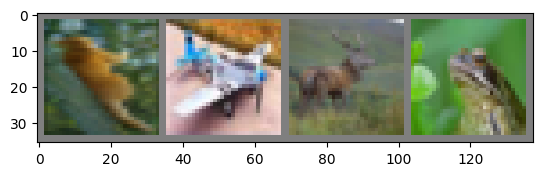

cat   plane deer  frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# BUILD MODEL

In [ ]:
import torch.optim as optim

net = ResNet34()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
for epoch in range(3):
  running_loss=0.0
  for i, data in enumerate(trainloader,0):
    inputs,labels=data
  
  optimizer.zero_grad()
  outputs = net(inputs)
  loss=criterion(outputs,labels)
  loss.backward()
  optimizer.step()

  # print statistics
  running_loss += loss.item()
  if i % 2000 == 1999:
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    running_loss = 0.0

print('Finished Training')


Finished Training


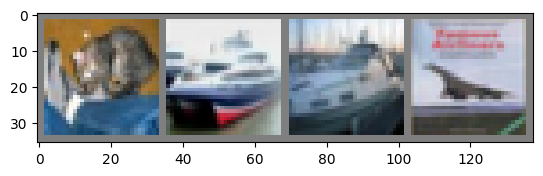

GroundTruth:  cat   ship  ship  plane


In [ ]:
#test
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range()))